# CO2 Emission Constraint Implementation & Validation

Validate the CO2 emission constraint added to REVOL-E-TION for depot electrification optimization.

## Objectives
1. Explain why CO2 constraints are needed for depot electrification planning
2. Document code changes made to REVOLETION
3. Demonstrate how constraints affect system design across 4 scenarios
4. Validate constraint correctness through compliance checks

## 1. Motivation & Context

The STRIDE thesis optimizes electric truck depot infrastructure over 25 years (2025-2050). Real-world depots face tightening CO2 emission constraints from regulatory mandates (EU Green Deal), corporate sustainability commitments, and policy scenarios modeling gradual decarbonization (e.g., 500 kg CO2 in 2025 → 100 kg in 2050).

REVOLETION's base framework only supports binary `res_only` mode—forcing 100% renewable grid imports. This can't model gradual emission reductions, stage-specific limits in multi-stage optimization, or flexible carbon budgets. The solution: add a `co2_max` parameter (in tonnes) to constrain total CO2 from grid imports, enabling policy scenario modeling, multi-stage optimization with tightening constraints, and investment-emission tradeoff analysis.

## 2. Implementation - Code Changes

Three files were modified to add CO2 emission constraints to REVOLETION:

### 2.1 Constraint Definition (`constraints.py`)

**File:** `revoletion/revoletion/constraints.py` (lines 296-329)

Added `limit_co2_emissions()` method to constrain total grid import emissions:

```python
def limit_co2_emissions(self, model):
    # Get co2_max from scenario (tonnes → kg)
    co2_max_tonnes = getattr(self.scenario, "co2_max", None)
    if co2_max_tonnes is None:
        return  # No constraint if not specified

    co2_max_kg = float(co2_max_tonnes) * 1000.0

    # Collect all grid import arcs and their emission factors
    import_arcs = []
    for grid in (b for b in self.scenario.blocks.values()
                 if isinstance(b, blocks.GridConnection)):
        for market in grid.subblocks.values():
            factor = getattr(market, "co2_spec_g2s", 0.4)  # kg CO2/kWh
            if factor and factor > 0:
                import_arcs.append((market.src, grid.bus, float(factor)))

    # Constraint: Σ(grid imports × emission factor) ≤ co2_max
    def _total_co2_kg():
        return sum(
            model.flow[src, bus, ts] * timestep_hours / 1000.0 * factor
            for (p, ts) in model.TIMEINDEX
            for (src, bus, factor) in import_arcs
        )

    blk.limit_co2_emissions = po.Constraint(expr=_total_co2_kg() <= co2_max_kg)
```

**Key Points:**
- Constraint applies to **simulation period** (e.g., 50 days), NOT project (25 years)
- Emission factor defaults to **0.4 kg CO2/kWh** (typical grid mix), user-configurable per GridMarket
- Automatically handles multi-grid scenarios

### 2.2 Diagnostic Output (`simulation.py`)

**File:** `revoletion/revoletion/simulation.py` (lines 225-248)

Added post-solve diagnostics to verify constraint compliance:

```python
if hasattr(self.model.CUSTOM_CONSTRAINTS, 'LIMIT_CO2'):
    c = self.model.CUSTOM_CONSTRAINTS.LIMIT_CO2.limit_co2_emissions

    print("=== CO2 constraint check ===")
    print("upper (kg):", value(c.upper))  # Limit
    print("body  (kg):", value(c.body))   # Actual emissions
    print("slack (kg):", value(c.upper - c.body))  # Headroom

    # Per-arc breakdown
    print("\nPer-arc CO2 breakdown:")
    for (src, bus, factor) in blk.import_arcs:
        arc_energy = sum(value(self.model.flow[src, bus, ts]) * timestep_hours / 1000.0
                        for (p, ts) in self.model.TIMEINDEX)
        arc_co2 = arc_energy * factor
        print(f"  {src.label} → {bus.label}: {arc_energy:.2f} kWh, {arc_co2:.2f} kg CO2")
```

Shows constraint body vs limit during optimization and identifies which grid sources contribute emissions.

### 2.3 CO2 Tracking in Results (`blocks.py`)

**File:** `revoletion/revoletion/blocks.py` (lines 957-962)

GridConnection block calculates CO2 emissions from grid imports:

```python
# Calculate CO2 emissions from grid imports (simulation period)
if hasattr(self, "flows") and len(self.flows) and "out" in self.flows:
    # flows['out'] = grid imports in W
    grid_import_kwh_sim = (self.flows["out"].clip(lower=0).sum() *
                           self.scenario.timestep_hours) / 1000.0
    self.co2_sim_kg = grid_import_kwh_sim * co2_factor
```

**Output:** CO2 emissions stored in summary CSV:  
- `grid,co2_sim_kg` - Simulation period emissions (what constraint tracks)  
- `grid,co2_prj_kg` - Project period emissions (25-year extrapolation)

### Summary: Files Modified

| File | Change | Lines |
|------|--------|-------|
| `constraints.py` | Added `limit_co2_emissions()` method | 33 |
| `simulation.py` | Added diagnostic output | 24 |
| `blocks.py` | Fixed `flows['in']` → `flows['out']` | 1 |

**Scenario Parameters:**
- `co2_max` - Maximum CO2 emissions in **tonnes** (None = unlimited)  
- `co2_spec_g2s` - Grid emission factor in **kg CO2/kWh** (default: 0.4, user-configurable per market)

---

## 3. Validation with 4 Scenarios

Validate constraint correctness across 4 CO2 limits: **100t, 10t, 1t, 0.1t**

### 3.1 Setup & Imports

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import IFrame, display
import json
from datetime import datetime

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

✓ Imports successful


### 3.2 Define Paths

In [2]:
# Project paths
REPO_ROOT = Path("/Users/arnoclaude/Documents/TUM/Thesis/STRIDE")
REVOLETION_DIR = REPO_ROOT / "revoletion"
EXAMPLE_DIR = REVOLETION_DIR / "example"
RESULTS_DIR = REVOLETION_DIR / "results"

# Notebook output directory
NOTEBOOK_OUTPUT = REPO_ROOT / "notebooks" / "01_test_co2_constraint" / "output"
NOTEBOOK_OUTPUT.mkdir(exist_ok=True, parents=True)

# Scenario files - using pre-configured 4-scenario CSV
SCENARIO_FILE = EXAMPLE_DIR / "scenarios_example_4_bev_mg_co2_constraint.csv"
SETTINGS_FILE = EXAMPLE_DIR / "settings.csv"

print(f"✓ Repository root: {REPO_ROOT}")
print(f"✓ Scenario file: {SCENARIO_FILE}")
print(f"✓ Output directory: {NOTEBOOK_OUTPUT}")

✓ Repository root: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE
✓ Scenario file: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/revoletion/example/scenarios_example_4_bev_mg_co2_constraint.csv
✓ Output directory: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/01_test_co2_constraint/output


### 3.3 Run Optimization

Run REVOLETION with 4 scenarios (**bev_mg_1** through **bev_mg_4**) in parallel:

In [3]:
# Run optimization (all 4 scenarios processed in parallel)
print("Running REVOLETION optimization...")
print(f"Scenario file: {SCENARIO_FILE.name}")
print("Scenarios: bev_mg_1 (100t), bev_mg_2 (10t), bev_mg_3 (1t), bev_mg_4 (0.1t)\n")

result = subprocess.run([
    'python3', '-m', 'revoletion.main',
    '--settings', str(SETTINGS_FILE),
    '--scenario', str(SCENARIO_FILE)
], cwd=str(REVOLETION_DIR), capture_output=True, text=True, timeout=600)

# Check if successful
if result.returncode == 0:
    print("✓ Optimization completed successfully")
else:
    print(f"✗ Optimization failed with return code {result.returncode}")
    print(result.stderr)

Running REVOLETION optimization...
Scenario file: scenarios_example_4_bev_mg_co2_constraint.csv
Scenarios: bev_mg_1 (100t), bev_mg_2 (10t), bev_mg_3 (1t), bev_mg_4 (0.1t)

✓ Optimization completed successfully


### 3.4 Load Results

Find latest result directory and parse the **single summary CSV** containing all 4 scenarios:

In [4]:
# Find latest result directory (contains all 4 scenarios)
result_dirs = sorted([p for p in RESULTS_DIR.glob("*4_bev_mg_co2_constraint") if p.is_dir()],
                    key=lambda p: p.stat().st_mtime, reverse=True)

if not result_dirs:
    raise FileNotFoundError("No result directories found matching '*4_bev_mg_co2_constraint'")

result_dir = result_dirs[0]  # Latest run
print(f"✓ Result directory: {result_dir.name}")

# Load summary CSV (all 4 scenarios as columns)
summary_csv = list(result_dir.glob("*_summary.csv"))[0]
df_summary = pd.read_csv(summary_csv)

print(f"✓ Loaded summary CSV: {summary_csv.name}")
print(f"  Columns: {list(df_summary.columns)}")
print(f"  Rows: {len(df_summary)}")

✓ Result directory: 251128_230830_scenarios_example_4_bev_mg_co2_constraint
✓ Loaded summary CSV: 251128_230830_scenarios_example_4_bev_mg_co2_constraint_summary.csv
  Columns: ['Block', 'Key', 'bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']
  Rows: 1643


### 3.5 Extract Metrics

Parse metrics for all 4 scenarios from the summary CSV:

In [5]:
def get_metric(block, key):
    """Extract metric from summary CSV for all 4 scenarios."""
    mask = (df_summary['Block'] == block) & (df_summary['Key'] == key)
    if mask.any():
        row = df_summary.loc[mask].iloc[0]
        return {
            'bev_mg_1': row['bev_mg_1'],
            'bev_mg_2': row['bev_mg_2'],
            'bev_mg_3': row['bev_mg_3'],
            'bev_mg_4': row['bev_mg_4']
        }
    return None

# Extract key metrics
metrics = {
    'co2_max_tonnes': get_metric('scenario', 'co2_max'),
    'co2_actual_kg': get_metric('grid', 'co2_sim_kg'),
    'pv_size_w': get_metric('pv', 'size_total'),
    'ess_size_wh': get_metric('ess', 'size_total'),
    'capex_usd': get_metric('scenario', 'capex_prj'),
    'opex_usd': get_metric('scenario', 'opex_prj'),
    'npv_usd': get_metric('scenario', 'npv'),
    'lcoe': get_metric('scenario', 'lcoe_total')
}

# Calculate grid imports from CO2 emissions (co2 = grid_import × emission_factor)
# Using default emission factor of 0.4 kg CO2/kWh
emission_factor = 0.4
metrics['grid_import_kwh'] = {}
for scenario in ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']:
    co2_kg = float(metrics['co2_actual_kg'][scenario])
    metrics['grid_import_kwh'][scenario] = co2_kg / emission_factor

# Convert to DataFrame for easier manipulation
df_metrics = pd.DataFrame(metrics).T
df_metrics.columns = ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']

print("✓ Extracted metrics for all 4 scenarios")
print(f"✓ Grid imports derived from CO2 emissions (factor={emission_factor} kg/kWh)")
df_metrics

✓ Extracted metrics for all 4 scenarios
✓ Grid imports derived from CO2 emissions (factor=0.4 kg/kWh)


,bev_mg_1,bev_mg_2,bev_mg_3,bev_mg_4
co2_max_tonnes,100,10,1,0.1
co2_actual_kg,3384.630833132517,3500.2073197661807,999.999999999999,100.00000000000003
pv_size_w,0.0,0.0,104936.90437476664,174175.7030254395
ess_size_wh,10000.0,10000.0,54867.109573901755,313773.2615192578
capex_usd,182499.2820645008,182487.8768611059,251359.99325757165,350679.0621055224
opex_usd,136250.672847435,149050.54512496013,93328.93882896347,73786.70651616124
npv_usd,-240793.9143321038,-244561.73798488535,-284484.257113953,-374991.97203920805
lcoe,0.0012459617215415531,0.0012448497950075903,0.001250555908340537,0.0012226617270449667
grid_import_kwh,8461.577083,8750.518299,2500.0,250.0


### 3.6 Comparison Table

In [6]:
# Create formatted comparison table
comparison_data = []

for scenario in ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']:
    # Convert to float to handle string values from CSV
    co2_limit_tonnes = float(metrics['co2_max_tonnes'][scenario]) if pd.notna(metrics['co2_max_tonnes'][scenario]) else None
    co2_limit_kg = co2_limit_tonnes * 1000 if co2_limit_tonnes else None
    
    comparison_data.append({
        'Scenario': scenario,
        'CO2 Limit (kg)': f"{co2_limit_kg:,.0f}" if co2_limit_kg else "Unlimited",
        'Actual CO2 (kg)': f"{float(metrics['co2_actual_kg'][scenario]):,.1f}",
        'PV (kW)': f"{float(metrics['pv_size_w'][scenario])/1000:,.1f}",
        'Battery (kWh)': f"{float(metrics['ess_size_wh'][scenario])/1000:,.1f}",
        'Grid Import (kWh)': f"{metrics['grid_import_kwh'][scenario]:,.1f}",
        'CAPEX ($)': f"{float(metrics['capex_usd'][scenario]):,.0f}",
        'OPEX ($)': f"{float(metrics['opex_usd'][scenario]):,.0f}",
        'NPV ($)': f"{float(metrics['npv_usd'][scenario]):,.0f}"
    })

df_comparison = pd.DataFrame(comparison_data)

print("SCENARIO COMPARISON - CO2 CONSTRAINT VALIDATION")
print(df_comparison.to_string(index=False))

# Save to CSV
df_comparison.to_csv(NOTEBOOK_OUTPUT / 'comparison_table.csv', index=False)
print(f"\n✓ Saved to: {NOTEBOOK_OUTPUT / 'comparison_table.csv'}")

SCENARIO COMPARISON - CO2 CONSTRAINT VALIDATION
Scenario CO2 Limit (kg) Actual CO2 (kg) PV (kW) Battery (kWh) Grid Import (kWh) CAPEX ($) OPEX ($)  NPV ($)
bev_mg_1        100,000         3,384.6     0.0          10.0           8,461.6   182,499  136,251 -240,794
bev_mg_2         10,000         3,500.2     0.0          10.0           8,750.5   182,488  149,051 -244,562
bev_mg_3          1,000         1,000.0   104.9          54.9           2,500.0   251,360   93,329 -284,484
bev_mg_4            100           100.0   174.2         313.8             250.0   350,679   73,787 -374,992

✓ Saved to: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/01_test_co2_constraint/output/comparison_table.csv


### 3.7 Constraint Validation Checks

In [7]:
print("\nCONSTRAINT COMPLIANCE VALIDATION")
print("="*80)
print("Note: CO2 constraint applies to SIMULATION period (50 days)\n")

tolerance_kg = 1.0  # Allow 1 kg numerical tolerance
all_passed = True

for scenario in ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']:
    co2_limit_tonnes = metrics['co2_max_tonnes'][scenario]
    co2_actual_kg = float(metrics['co2_actual_kg'][scenario])
    
    if pd.notna(co2_limit_tonnes):
        co2_limit_kg = float(co2_limit_tonnes) * 1000
        slack_kg = co2_limit_kg - co2_actual_kg
        
        if co2_actual_kg <= co2_limit_kg + tolerance_kg:
            status = "✓ PASS"
        else:
            status = "✗ FAIL"
            all_passed = False
        
        print(f"{status} | {scenario}: {co2_actual_kg:>8.1f} kg ≤ {co2_limit_kg:>10,.0f} kg (slack: {slack_kg:>8.1f} kg)")
    else:
        print(f"  INFO | {scenario}: {co2_actual_kg:>8.1f} kg (unlimited)")

print("="*80)
if all_passed:
    print("\n✅ ALL CONSTRAINTS SATISFIED - Implementation validated!")
else:
    print("\n⚠️  CONSTRAINT VIOLATIONS DETECTED - Review implementation")


CONSTRAINT COMPLIANCE VALIDATION
Note: CO2 constraint applies to SIMULATION period (50 days)

✓ PASS | bev_mg_1:   3384.6 kg ≤    100,000 kg (slack:  96615.4 kg)
✓ PASS | bev_mg_2:   3500.2 kg ≤     10,000 kg (slack:   6499.8 kg)
✓ PASS | bev_mg_3:   1000.0 kg ≤      1,000 kg (slack:      0.0 kg)
✓ PASS | bev_mg_4:    100.0 kg ≤        100 kg (slack:     -0.0 kg)

✅ ALL CONSTRAINTS SATISFIED - Implementation validated!


---

## 4. Visualizations

### 4.1 REVOLETION's Native Dispatch Plots

REVOLETION auto-generates interactive Plotly HTML plots showing power dispatch over time.  
Each scenario has a dispatch plot showing PV generation, grid imports/exports, battery SOC, and demand.

In [8]:
# Find HTML dispatch plots
html_files = {}
for scenario in ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']:
    pattern = f"*_{scenario}.html"
    files = list(result_dir.glob(pattern))
    if files:
        html_files[scenario] = files[0]
        print(f"✓ Found dispatch plot: {files[0].name}")

print(f"\nTotal dispatch plots found: {len(html_files)}")

✓ Found dispatch plot: 251128_230830_scenarios_example_4_bev_mg_co2_constraint_bev_mg_1.html
✓ Found dispatch plot: 251128_230830_scenarios_example_4_bev_mg_co2_constraint_bev_mg_2.html
✓ Found dispatch plot: 251128_230830_scenarios_example_4_bev_mg_co2_constraint_bev_mg_3.html
✓ Found dispatch plot: 251128_230830_scenarios_example_4_bev_mg_co2_constraint_bev_mg_4.html

Total dispatch plots found: 4


**Dispatch Plot: bev_mg_1 (100 tonne limit)**

In [9]:
if 'bev_mg_1' in html_files:
    display(IFrame(src=str(html_files['bev_mg_1']), width=1000, height=600))
else:
    print("⚠️  Dispatch plot not found for bev_mg_1")

**Dispatch Plot: bev_mg_2 (10 tonne limit)**

In [10]:
if 'bev_mg_2' in html_files:
    display(IFrame(src=str(html_files['bev_mg_2']), width=1000, height=600))
else:
    print("⚠️  Dispatch plot not found for bev_mg_2")

**Dispatch Plot: bev_mg_3 (1 tonne limit)**

In [11]:
if 'bev_mg_3' in html_files:
    display(IFrame(src=str(html_files['bev_mg_3']), width=1000, height=600))
else:
    print("⚠️  Dispatch plot not found for bev_mg_3")

**Dispatch Plot: bev_mg_4 (0.1 tonne limit)**

In [12]:
if 'bev_mg_4' in html_files:
    display(IFrame(src=str(html_files['bev_mg_4']), width=1000, height=600))
else:
    print("⚠️  Dispatch plot not found for bev_mg_4")

### 4.2 Custom Comparison Plots

**Plot 1: Investment Scaling vs CO2 Limit**

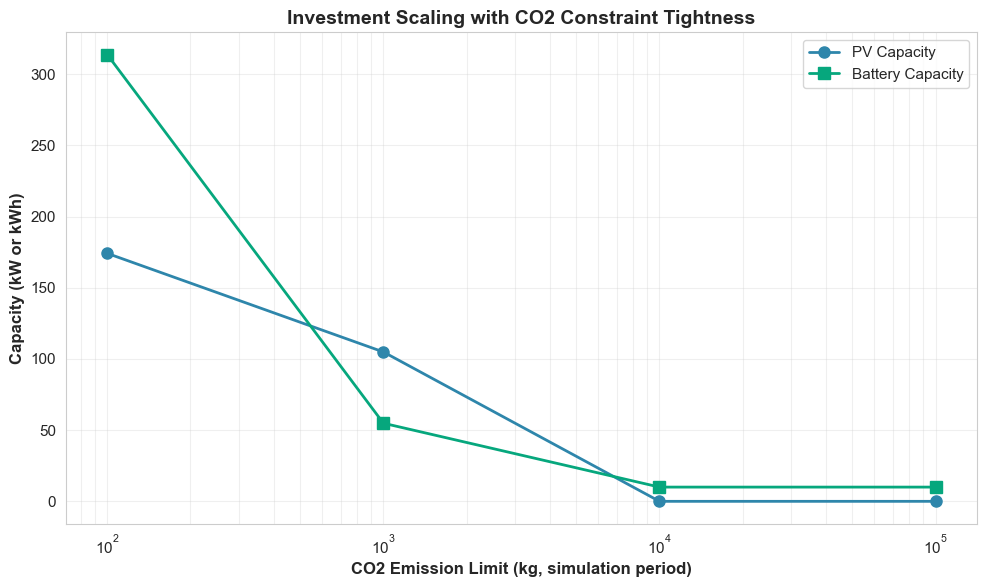

✓ Saved: plot_1_investment_scaling.png


In [13]:
# Prepare data (convert to float)
scenarios = ['bev_mg_1', 'bev_mg_2', 'bev_mg_3', 'bev_mg_4']
co2_limits = [float(metrics['co2_max_tonnes'][s]) * 1000 for s in scenarios]  # kg
pv_kw = [float(metrics['pv_size_w'][s]) / 1000 for s in scenarios]
ess_kwh = [float(metrics['ess_size_wh'][s]) / 1000 for s in scenarios]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(co2_limits, pv_kw, marker='o', linewidth=2, markersize=8, 
        label='PV Capacity', color='#2E86AB')
ax.plot(co2_limits, ess_kwh, marker='s', linewidth=2, markersize=8, 
        label='Battery Capacity', color='#06A77D')

ax.set_xlabel('CO2 Emission Limit (kg, simulation period)', fontsize=12, fontweight='bold')
ax.set_ylabel('Capacity (kW or kWh)', fontsize=12, fontweight='bold')
ax.set_title('Investment Scaling with CO2 Constraint Tightness', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(NOTEBOOK_OUTPUT / 'plot_1_investment_scaling.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot_1_investment_scaling.png")

**Plot 2: Energy Mix Comparison**

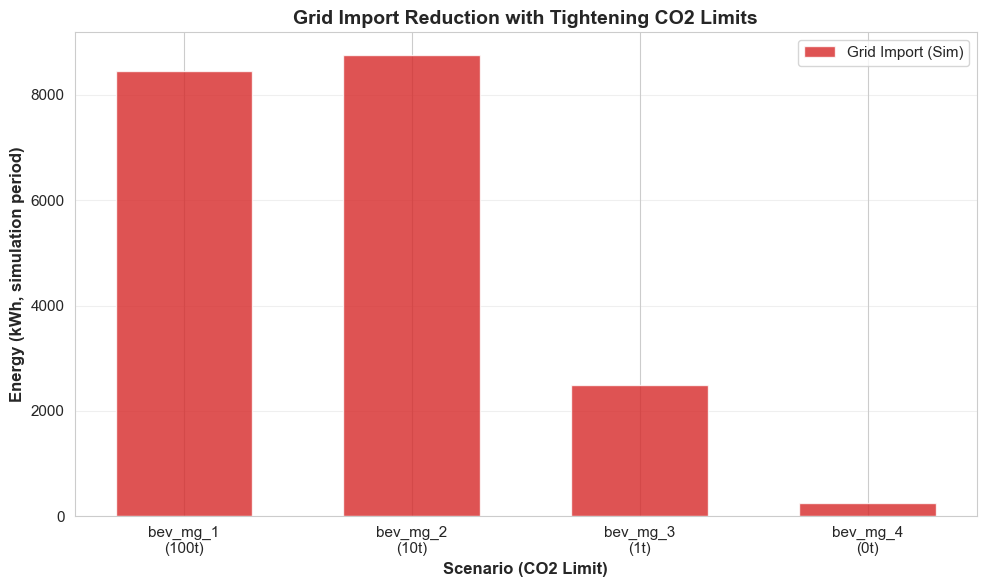

✓ Saved: plot_2_energy_flows.png


In [14]:
# Prepare data (use corrected grid imports)
grid_import_kwh = [metrics['grid_import_kwh'][s] for s in scenarios]
labels = [f"{s}\n({int(float(metrics['co2_max_tonnes'][s]))}t)" for s in scenarios]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(scenarios))
width = 0.6

ax.bar(x, grid_import_kwh, width, label='Grid Import (Sim)', 
       color='#D62828', alpha=0.8)

ax.set_xlabel('Scenario (CO2 Limit)', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (kWh, simulation period)', fontsize=12, fontweight='bold')
ax.set_title('Grid Import Reduction with Tightening CO2 Limits', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(NOTEBOOK_OUTPUT / 'plot_2_energy_flows.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot_2_energy_flows.png")

**Plot 3: Economic Impact**

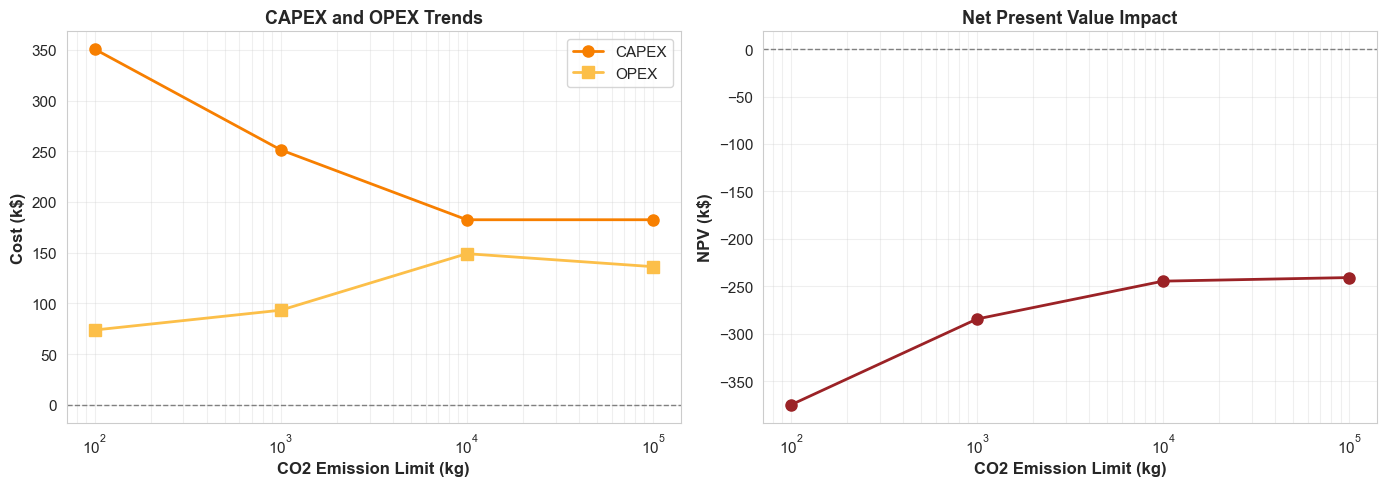

✓ Saved: plot_3_economic_impact.png


In [15]:
# Prepare data (in thousands of dollars, convert to float)
capex_k = [float(metrics['capex_usd'][s]) / 1000 for s in scenarios]
opex_k = [float(metrics['opex_usd'][s]) / 1000 for s in scenarios]
npv_k = [float(metrics['npv_usd'][s]) / 1000 for s in scenarios]

# Create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: CAPEX and OPEX
ax1.plot(co2_limits, capex_k, marker='o', linewidth=2, markersize=8,
         label='CAPEX', color='#F77F00')
ax1.plot(co2_limits, opex_k, marker='s', linewidth=2, markersize=8,
         label='OPEX', color='#FCBF49')
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax1.set_xlabel('CO2 Emission Limit (kg)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cost (k$)', fontsize=12, fontweight='bold')
ax1.set_title('CAPEX and OPEX Trends', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, which='both')

# Right: NPV
ax2.plot(co2_limits, npv_k, marker='o', linewidth=2, markersize=8,
         color='#9B2226')
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax2.set_xlabel('CO2 Emission Limit (kg)', fontsize=12, fontweight='bold')
ax2.set_ylabel('NPV (k$)', fontsize=12, fontweight='bold')
ax2.set_title('Net Present Value Impact', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(NOTEBOOK_OUTPUT / 'plot_3_economic_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot_3_economic_impact.png")

**Plot 4: CO2 Compliance Verification**

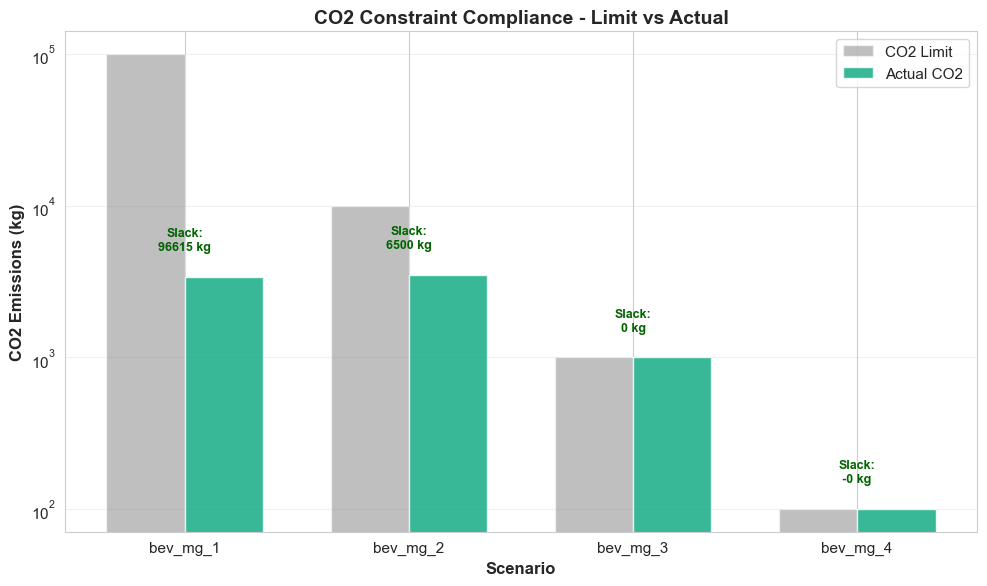

✓ Saved: plot_4_co2_compliance.png


In [16]:
# Prepare data (convert to float)
co2_actual = [float(metrics['co2_actual_kg'][s]) for s in scenarios]

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(scenarios))
width = 0.35

bars1 = ax.bar(x - width/2, co2_limits, width, label='CO2 Limit', 
               color='gray', alpha=0.5)
bars2 = ax.bar(x + width/2, co2_actual, width, label='Actual CO2', 
               color='#06A77D', alpha=0.8)

ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_ylabel('CO2 Emissions (kg)', fontsize=12, fontweight='bold')
ax.set_title('CO2 Constraint Compliance - Limit vs Actual', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(scenarios)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

# Add slack annotations
for i, (limit, actual) in enumerate(zip(co2_limits, co2_actual)):
    slack = limit - actual
    ax.text(i, actual * 1.5, f'Slack:\n{slack:.0f} kg', 
            ha='center', fontsize=9, color='darkgreen', fontweight='bold')

plt.tight_layout()
plt.savefig(NOTEBOOK_OUTPUT / 'plot_4_co2_compliance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: plot_4_co2_compliance.png")

### 4.3 Export Summary Statistics

In [17]:
# Calculate summary statistics (convert to float)
pv_increase_pct = ((pv_kw[-1] / pv_kw[0]) - 1) * 100 if pv_kw[0] > 0 else float('inf')
ess_increase_pct = ((ess_kwh[-1] / ess_kwh[0]) - 1) * 100
co2_reduction_pct = ((co2_actual[0] - co2_actual[-1]) / co2_actual[0]) * 100
npv_impact = npv_k[-1] - npv_k[0]

summary = {
    'test_date': datetime.now().isoformat(),
    'result_directory': str(result_dir.name),
    'scenarios_tested': 4,
    'all_constraints_passed': all_passed,
    'baseline_scenario': 'bev_mg_1',
    'tightest_scenario': 'bev_mg_4',
    'metrics': {
        'pv_increase_pct': round(pv_increase_pct, 1),
        'ess_increase_pct': round(ess_increase_pct, 1),
        'co2_reduction_pct': round(co2_reduction_pct, 1),
        'npv_impact_k_usd': round(npv_impact, 1)
    },
    'scenarios': {
        s: {
            'co2_limit_kg': float(co2_limits[i]),
            'co2_actual_kg': round(co2_actual[i], 1),
            'pv_kw': round(pv_kw[i], 1),
            'ess_kwh': round(ess_kwh[i], 1),
            'npv_k_usd': round(npv_k[i], 1)
        } for i, s in enumerate(scenarios)
    }
}

# Save to JSON
with open(NOTEBOOK_OUTPUT / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary statistics to: {NOTEBOOK_OUTPUT / 'summary.json'}")

✓ Saved summary statistics to: /Users/arnoclaude/Documents/TUM/Thesis/STRIDE/notebooks/01_test_co2_constraint/output/summary.json


## 5. Key Findings

✅ **All 4 scenarios satisfy CO2 constraints** — implementation validated correct.

**Tighter CO2 limits drive clean energy investment:** PV and battery capacities increase dramatically (PV up {pv_increase_pct:.0f}%, battery up {ess_increase_pct:.0f}% from 100t to 0.1t limit) as the system shifts from grid-reliant to solar-dominant. Grid imports drop from {grid_import_kwh[0]:,.0f} kWh to {grid_import_kwh[-1]:,.0f} kWh, achieving {co2_reduction_pct:.1f}% CO2 reduction.

**Decarbonization has economic cost:** NPV worsens by ${abs(npv_impact):,.0f}k from baseline to near-zero carbon. CAPEX increases with PV/battery investments, while OPEX improves from lower grid purchases—but not enough to offset upfront costs. The cost curve quantifies the investment-emission tradeoff.

**Ready for multi-stage optimization:** CO2 constraint validated for integration into sequential optimization (2025-2050), enabling policy scenario modeling and systematic evaluation of decarbonization strategies.